In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
# from omni import *
from mixup import * 

In [2]:
"""
Creates a MobileNetV3 Model as defined in:
Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
Searching for MobileNetV3
arXiv preprint arXiv:1905.02244.
"""

import torch.nn as nn
import math


__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=1000, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}
        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t, c, SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k, t, c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Training

In [4]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

In [5]:
def load_data(data_dir, download = True):

  transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  train_data = datasets.CIFAR10(
      root = data_dir, train = True,
      download = download, transform = transform
  )

  test_data = datasets.CIFAR10(
      root = data_dir, train = False,
      download = download, transform = transform
  )

  return (train_data, test_data)

train_data, test_data = load_data('./data/cifar10')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
batch_size = 128
num_workers = 4

train_loader = DataLoader(train_data, batch_size = batch_size,
                          shuffle = True, num_workers = num_workers)
test_loader = DataLoader(test_data, batch_size = batch_size,
                         shuffle = True, num_workers = num_workers)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
import logging
import os
from tqdm.notebook import tqdm

def check_logging_directory(path):
  parent_directory = os.path.dirname(path)
  if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    print("Create new directory")

logging_path = './logging/mixup_mobilenetv3_normallarge_cifar10.log'
check_logging_directory(logging_path)

logging.basicConfig(filename=logging_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [9]:
!pip install gradient-descent-the-ultimate-optimizer

In [10]:
from gradient_descent_the_ultimate_optimizer import gdtuo

criterion = nn.CrossEntropyLoss().to(device)

num_epochs = 100

mobile_v3 = mobilenetv3_large(num_classes = 10).to(device)
optim = gdtuo.Adam(optimizer=gdtuo.SGD(1e-5))
mw = gdtuo.ModuleWrapper(mobile_v3, optimizer=optim)
mw.initialize()

print(f"The number of parameters: {count_parameters(mobile_v3)}")


The number of parameters: 4214842


In [11]:
from thop import profile

input_size = (1, 3, 224, 224)

flops, params = profile(mobile_v3, inputs=(torch.randn(*input_size).to(device),))
print(f"FLOPs: {flops / 1e9} billion")
print(f"Parameters: {params / 1e6} million")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
FLOPs: 0.233571256 billion
Parameters: 4.214842 million


In [12]:
# Huấn luyện mô hình
train_loss, val_loss = [], []
train_acc, val_acc = [], []

epoch_bar = tqdm(desc = 'Epoch',
                 total = num_epochs, position = 1)
train_bar = tqdm(desc = 'Training', total = len(train_loader),
                 position = 1, leave = True)
val_bar = tqdm(desc = 'Validation', total = len(test_loader),
               position = 1, leave = True)

print("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")
logging.info("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")

for epoch in range(num_epochs):

    epoch_bar.set_description(f'Epoch {epoch + 1}/{num_epochs}')

    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    for i, (X, y) in enumerate(train_loader):

        mw.begin()
        mw.zero_grad()
        X, y = X.to(device), y.to(device)
        X, y_origin, y_sampled, lam = mixup_data(X, y, device, alpha = 0.4)
        
        # Forward pass
        output = mw.forward(X)
        loss = mixup_criterion(criterion, output, y_origin, y_sampled, lam)
        
        # Backward pass
        loss.backward(create_graph = True)
        mw.step()
    
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (i + 1)
        total_loss += loss_t
        
        # Calculating the accuracy
        _, predicted = torch.max(output.data, 1)
        n_correct = (lam * predicted.eq(y_origin.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(y_sampled.data).cpu().sum().float())

        acc_t = n_correct / len(predicted) * 100
        running_acc += (acc_t - running_acc) / (i + 1)

        total_acc += n_correct
        total += y.shape[0]


        train_bar.set_postfix(loss = running_loss,
                              acc = f"{running_acc:.2f}%",
                              epoch = epoch + 1)
        train_bar.update()

    # mw.begin()
    current_loss = total_loss / len(train_loader)
    current_acc = total_acc / total * 100
    train_loss.append(current_loss)
    train_acc.append(current_acc)

    print("========================================")
    print("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    print(f"Train Loss: {current_loss:.2f}\t|\tTrain Acc: {current_acc:.2f}%")

    logging.info("========================================")
    logging.info("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    logging.info(f"Train Loss: {current_loss:.2f}  -   Train Acc: {current_acc:.2f}%")


    # Eval trên valid set
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    # mw.end()
    # mw.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(device), y.to(device)
            # Forward pass
            output = mw.forward(X)

            # Calculate Loss
            loss = criterion(output, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)
            total_loss += loss_t

            # Calculate Accuracies
            _, predicted = torch.max(output.data, 1)
            n_correct = (predicted == y).sum().item()
            acc_t = n_correct / len(predicted) * 100
            running_acc += (acc_t - running_acc) / (i + 1)
            total_acc += n_correct

            total += y.shape[0]

            val_bar.set_postfix(loss = running_loss,
                                acc = f"{running_acc:.2f}%",
                                epoch = epoch + 1)
            val_bar.update()

    current_loss = total_loss / len(test_loader)
    current_acc = total_acc / total * 100

    val_loss.append(current_loss)
    val_acc.append(current_acc)

    print(f"Val Loss: {current_loss:.2f}\t|\tVal Acc: {current_acc:.2f}%")
    logging.info(f"Val Loss: {current_loss:.2f}  -  Val Acc: {current_acc:.2f}%")

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()


print("========================================")
print("Training Completed! 😀")
logging.info("========================================")
logging.info("Training Completed! 😀")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/391 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀


/opt/conda/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/torch/csrc/autograd/engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/100
Train Loss: 1.79	|	Train Acc: 35.58%
Val Loss: 1.25	|	Val Acc: 55.73%
Epoch 2/100
Train Loss: 1.47	|	Train Acc: 50.87%
Val Loss: 1.03	|	Val Acc: 64.76%
Epoch 3/100
Train Loss: 1.32	|	Train Acc: 58.17%
Val Loss: 0.86	|	Val Acc: 71.18%
Epoch 4/100
Train Loss: 1.20	|	Train Acc: 62.84%
Val Loss: 0.78	|	Val Acc: 74.39%
Epoch 5/100
Train Loss: 1.21	|	Train Acc: 63.30%
Val Loss: 0.75	|	Val Acc: 76.33%
Epoch 6/100
Train Loss: 1.07	|	Train Acc: 68.59%
Val Loss: 0.62	|	Val Acc: 80.79%
Epoch 7/100
Train Loss: 1.00	|	Train Acc: 71.26%
Val Loss: 0.60	|	Val Acc: 81.49%
Epoch 8/100
Train Loss: 0.97	|	Train Acc: 72.13%
Val Loss: 0.59	|	Val Acc: 82.88%
Epoch 9/100
Train Loss: 0.97	|	Train Acc: 72.45%
Val Loss: 0.55	|	Val Acc: 82.21%
Epoch 11/100
Train Loss: 0.88	|	Train Acc: 75.44%
Val Loss: 0.50	|	Val Acc: 84.53%
Epoch 12/100
Train Loss: 0.82	|	Train Acc: 77.89%
Val Loss: 0.50	|	Val Acc: 84.24%
Epoch 13/100
Train Loss: 0.81	|	Train Acc: 77.90%
Val Loss: 0.59	|	Val Acc: 82.32%
Epoch 14/100


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 99/100
Train Loss: 0.60	|	Train Acc: 83.29%
Val Loss: 0.43	|	Val Acc: 89.67%
Epoch 100/100
Train Loss: 0.61	|	Train Acc: 83.47%
Val Loss: 0.40	|	Val Acc: 90.17%
Training Completed! 😀


  Using cached matplotlib-3.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.46.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (310 kB)
Creating a new directory


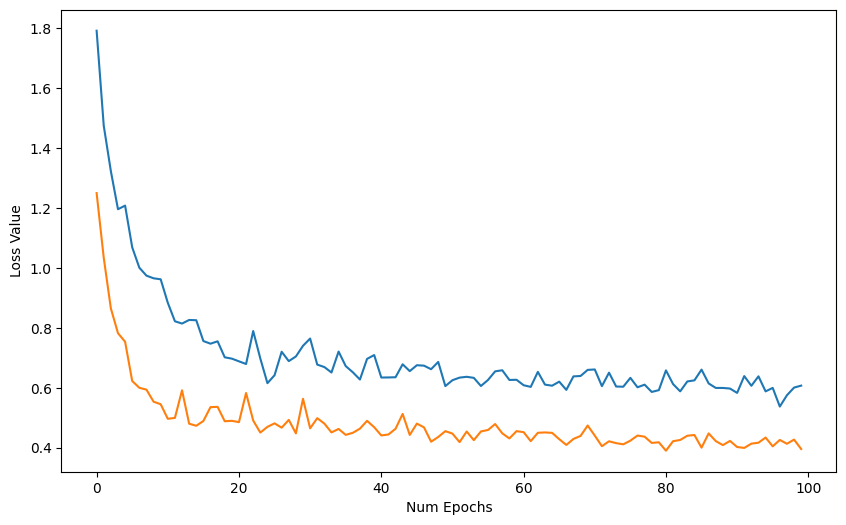

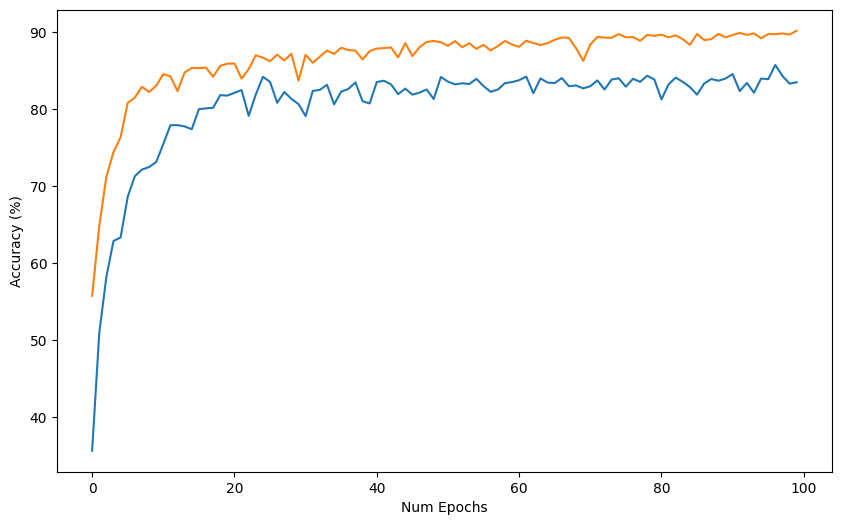

In [14]:
!pip install matplotlib
import matplotlib.pyplot as plt

if not os.path.exists("/plot"):
    os.makedirs("/plot")
    print("Creating a new directory")

def plot_loss(train_loss, val_loss, loss_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_loss)
    plt.plot(range(num_epochs), val_loss)

    plt.xlabel("Num Epochs")
    plt.ylabel("Loss Value")
    
    plt.savefig(loss_fig)
    plt.show()

def plot_accuracy(train_acc, val_acc, acc_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_acc)
    plt.plot(range(num_epochs), val_acc)

    plt.xlabel("Num Epochs")
    plt.ylabel("Accuracy (%)")
    
    plt.savefig(acc_fig)
    plt.show()

loss_path = "./plot/loss_fig_normal_cifar10(large).png"
acc_path = "./plot/acc_fig_normal_cifar10(large).png"

plot_loss(train_loss, val_loss, loss_path)
plot_accuracy(train_acc, val_acc, acc_path)


In [15]:
train_lowest_loss = np.argmin(train_loss)
train_highest_acc = np.argmax(train_acc)
print(f"The index of lowest train loss: {train_lowest_loss + 1}")
print(f"Train Loss: {train_loss[train_lowest_loss]}")
print(f"The index of highest train accuracy: {train_highest_acc + 1}")
print(f"Train Loss: {train_acc[train_highest_acc]}")

The index of lowest train loss: 97
Train Loss: 0.5371820116725267
The index of highest train accuracy: 97
Train Loss: 85.72026062011719


In [16]:
val_lowest_loss = np.argmin(val_loss)
val_highest_acc = np.argmax(val_acc)
print(f"The index of lowest train loss: {val_lowest_loss + 1}")
print(f"Train Loss: {val_loss[val_lowest_loss]}")
print(f"The index of highest train accuracy: {val_highest_acc + 1}")
print(f"Train Loss: {val_acc[val_highest_acc]}")

The index of lowest train loss: 81
Train Loss: 0.38975866742526427
The index of highest train accuracy: 100
Train Loss: 90.16999999999999
